# Project: Image Denoising(MNIST)

- Date:  July 16 2025 -  July 25 2025 ( with a great beak at one point)

- Description :
    In this second project , we will try to buld a model able to remove the nose of an image and give the most clear image possible.Otherwise here it will be only number. So the data set will be MNIST and we will see Auto-Encoder.

This project was also did en class but with Machine learning methods, what is the difference between this two approches?

In [14]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
#Normalization function
transform = transforms.Compose([
    transforms.ToTensor(),  #=> [0,1]
    transforms.Normalize(mean=(0.5,), std=(0.5,)) #=> [-1,1] 
    ])

# Download of the data
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set = datasets.MNIST(root="./data", train=False, download=True, transform=transform) # (10 000)

#Splitting
n_total=train_set.data.shape[0] # 60 000
n_train= int(n_total*0.8) #80% of the data (48 000)
n_val  = n_total - n_train #20% of the data (12 000)

train_ds, val_ds= random_split(train_set,[n_train, n_val],generator=torch.Generator().manual_seed(42))

# Dataloaders
train_loader= DataLoader(train_ds, batch_size=64,shuffle=True,  num_workers=2)
val_loader  = DataLoader(val_ds, batch_size=64,shuffle=False,  num_workers=2)
test_loader = DataLoader(test_set, batch_size=64,shuffle=False,  num_workers=2)

#Classes
classes=train_set.classes


In [3]:
#Some display to know more about the data
print(train_set)
print(train_set.data)
print(train_set[0])
print("Classes:\n", classes)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,

We can notice we have many -1 in the matrix which is absolutly normal.

In fact, we have images with only 0 and 1 pixels, so the 0 became (0-0.5)/0.5 = -1, and the 1 became (1-0.5)/0.5= +1. And because there was many black parts in the original image, many 0 , we have many -1. So it's not a mistake;) 

# Display of images

Let display all different classes

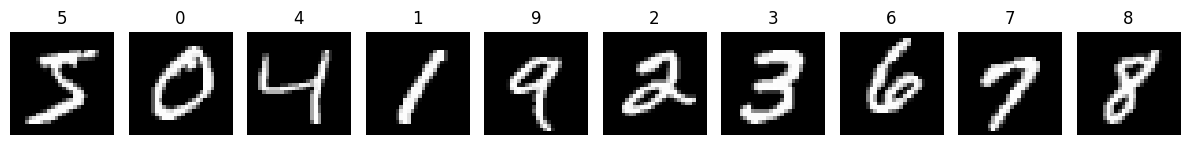

In [4]:
displayloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)


#Denormalization
mean = torch.tensor([0.5])[:, None, None]
std  = torch.tensor([0.5])[:, None, None]
# images_disp = images * std + mean  # values between 0 and 1

# We search an image for each class
samples= {}
for image, label in train_set:
    if label not in samples:
        samples[label]=image
    if len(samples)>=10:
        break

# Building the grid
fig, axes = plt.subplots(1, 10, figsize=(12, 1.5))
for ax, (digit, img) in zip(axes, samples.items()):
    img_denorm = img * std + mean             # retransforme en [0,1]
    np_img = img_denorm.squeeze().numpy()   # Tensor → ndarray
    ax.imshow(np_img, cmap="gray")
    ax.set_title(str(digit))
    ax.axis("off")

plt.tight_layout()
plt.show()


# Models

Now we will build our models for this project.

In [ ]:
# We build first a model with a fully-connected Encoder
class FCAutoEncoder(nn.Module):
    def __init__(self, bottleneck_dim=32):
        super().__init__()
        #Encoder
        self.encoder=nn.Sequential(
            nn.Flatten(), # 1x28x28 -> 784
            nn.Linear(784,300), # 784 -> 300
            nn.ReLU(),
            nn.Linear(300,100), # 300 -> 100
            nn.ReLU(),
            nn.Linear(100,bottleneck_dim) # 100 -> bottleneck_dim 
        )

        #Decoder
        self.decoder=nn.Sequential(
            nn.Linear(bottleneck_dim, 100), # bottleneck_dim -> 100
            nn.ReLU(),
            nn.Linear(100,300), # 100 -> 300
            nn.ReLU(),
            nn.Linear(300,784), # 300 -> 784
            nn.Tanh(), # output -> [-1,1]
            nn.Unflatten(1, (1,28,28)) # vector -> image(1x28x28) 
        )
    
    def forward(self,X):
        Y=self.encoder(X)
        return self.decoder(Y)

# A second model with 2 convolution layers
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Encoder
        self.encoder=nn.Sequential(
            nn.Conv2d(1,10,kernel_size=3,stride=1), # 1x28x28 -> 10x26x26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 10x26x26 -> 10x13x13
            nn.Conv2d(10,100,kernel_size=2,stride=1), # 10x13x13 -> 100x12x12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 100x12x12 -> 100x6x6
        )

        #Decoder
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=100, kernel_size=2, stride=2), #100x6x6 -> 100x12x12
            nn.ReLU(),
            nn.ConvTranspose2d(100, 10,kernel_size=2, stride=1), #100x12x12 -> 10x13x13
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=10, out_channels=10, kernel_size=2, stride=2), #10x13x13 -> 10x26x26
            nn.ReLU(),
            nn.ConvTranspose2d(10,1,kernel_size=3,stride=1) # 10x26x26 -> 1x28x28
        )

    def forward(self,X):
        Z=self.encoder(X)
        return self.decoder(Z)
    
# A variational AutoEncoder based on the last one
class VAE(nn.Module):
    def __init__(self,latent_dim=30):
        super().__init__()

        #Encoder
        self.encoder=nn.Sequential(
            nn.Conv2d(1,10,kernel_size=3,stride=1), # 1x28x28 -> 10x26x26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 10x26x26 -> 10x13x13
            nn.Conv2d(10,100,kernel_size=2,stride=1), # 10x13x13 -> 100x12x12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 100x12x12 -> 100x6x6
            nn.Flatten() # 100x6x6 -> 100*6*6 vector
        )

        # Mean (µ) and log of the standard deviation squared (log σ²) 
        self.mean=nn.Linear(100*6*6,latent_dim)
        self.log_std=nn.Linear(100*6*6, latent_dim)

        # Projection on the latent space or Sampling
        self.sample=nn.Linear(latent_dim, 100*6*6)

        #Decoder
        self.decoder=nn.Sequential(
            nn.Unflatten(1,(100,6,6)), # 100*6*6 vector -> 100x6x6
            nn.ConvTranspose2d(in_channels=100, out_channels=100, kernel_size=2, stride=2), #100x6x6 -> 100x12x12
            nn.ReLU(),
            nn.ConvTranspose2d(100, 10,kernel_size=2, stride=1), #100x12x12 -> 10x13x13
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=10, out_channels=10, kernel_size=2, stride=2), #10x13x13 -> 10x26x26
            nn.Tanh(), # output -> [-1,1] N.B: search about the right position of this activation function
            nn.ConvTranspose2d(10,1,kernel_size=3,stride=1) # 10x26x26 -> 1x28x28   
        )
    
    def reparametrization(self,mean,log_std):
        """ Return z = µ + epsilon*σ² with epsilon ~ N(0,1) """
        std=torch.exp(log_std) #σ²
        epsilon=torch.randn_like(log_std) #epsilon ~ N(0,1)
        return mean+epsilon*std # µ + epsilon*σ²
    
    def forward(self,x):
        #Encoding
        a=self.encoder(x)
        #Mean and standard deviation
        mean,log_std=self.mean(a),self.log_std(a)
        #Reparametrization 
        b=self.reparametrization(mean,log_std)
        # Sampling
        c=self.sample(b)
        #Decoder
        d=self.decoder(c)
        return d, mean, log_std

#Definition of VAE loss function 
def vae_loss(out_put, in_put, mean , log_std):
    """
    out_put : The output of the VAE.
    in_put: The target or initial image.
    mean : The mean
    log_std: The log of the standard deviation squared
    """
    # Reconstruction loss: difference of pixel between the prediction and the input or target 
    ce=torch.nn.functional.binary_cross_entropy(out_put, in_put,reduction="sum")
    ce=nn.functional.mse_loss(out_put, in_put,reduction="sum")
    # Kullback-Liebler divergence
    kl= -0.5*torch.sum(1+log_std-mean*mean - torch.exp(log_std))
    return ce+kl



                

# Training and Evaluation

We will train our models to re-build the correct image comme from a noisy image.
And to do that, we have many ways to proceed:
- we could add to each pixel a random value drawn from Normal Distribution N(0,σ²). It's called: Gaussian Noise.
- or, we could change a percentage of pixel by 0 or 1. It's called: Salt and Pepper (1-Salt, 0-pepper).

Let's start.

In [6]:
# Noise functions
# We will start with little std and then increase the intensity
def add_gaussian_noise(imgs,std=0.5):
    """
    Add Gaussian Noise to the image.
    img: Image(as a Pytorch Tensor).
    std: standard deviation squared.
    """
    noise =torch.randn_like(imgs) * std
    noisy_imgs= imgs + noise
    return torch.clamp(noisy_imgs, -1., 1.) # We clamp all value in [-1,1]

def add_salt_pepper(imgs, amount=0.3):
    """
    amount: percentage of image to modify.
    """
    B,C,H,W=imgs.shape
    noisy=imgs.clone() # a copy of imgs
    num_pixels=int(amount*H*W) #number of pixel to modify by image

    for i in range(B): # for every image in the batch
        idx=torch.randperm(H*W)[:num_pixels] # list of random pixels to change in the image
        # coordonate
        X=idx%W
        Y=idx//W
        #Modification (B,C,H,W)
        half = num_pixels // 2
        noisy[i, :, Y[:half], X[:half]] = 1.0   # salt
        noisy[i, :, Y[half:], X[half:]] = 0.0   # pepper
    return noisy 


In [11]:
print(len(train_loader))
print(750*64)
print(len(train_loader.dataset))

750
48000
48000


=======FC AUTO ENCODER=======


Époch 1/5 — Train MSE: 0.1587 
Époch 2/5 — Train MSE: 0.0969 
Époch 3/5 — Train MSE: 0.0844 
Époch 4/5 — Train MSE: 0.0778 
Époch 5/5 — Train MSE: 0.0736 
Runing Time:65.7510 seconds


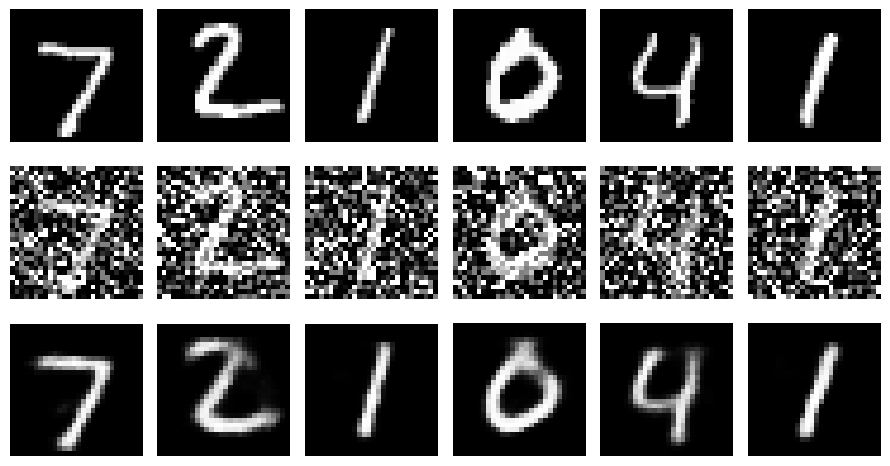

=======Conv AUTO ENCODER=======
Époch 1/5 — Train MSE: 0.1219 
Époch 2/5 — Train MSE: 0.0615 
Époch 3/5 — Train MSE: 0.0552 
Époch 4/5 — Train MSE: 0.0517 
Époch 5/5 — Train MSE: 0.0496 
Runing Time:203.5428 seconds


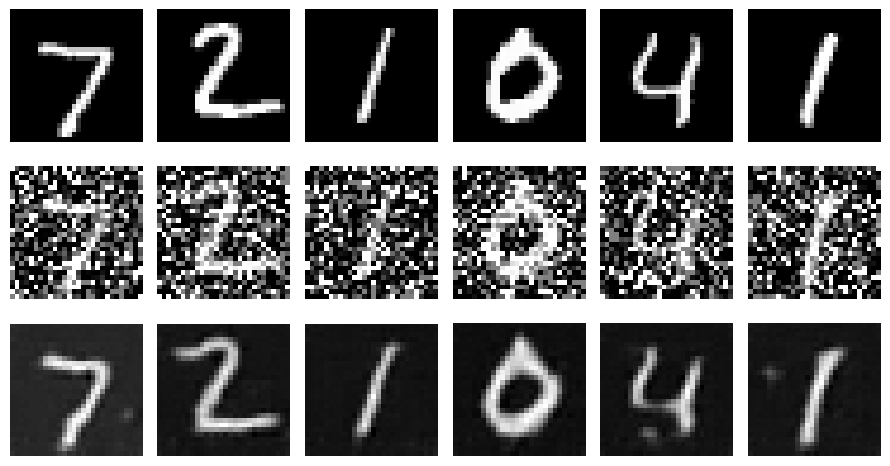

=======Var. AUTO ENCODER=======
Époch 1/5 — Train MSE: 0.1459 
Époch 2/5 — Train MSE: 0.0798 
Époch 3/5 — Train MSE: 0.0739 
Époch 4/5 — Train MSE: 0.0708 
Époch 5/5 — Train MSE: 0.0688 
Runing Time:204.4807 seconds


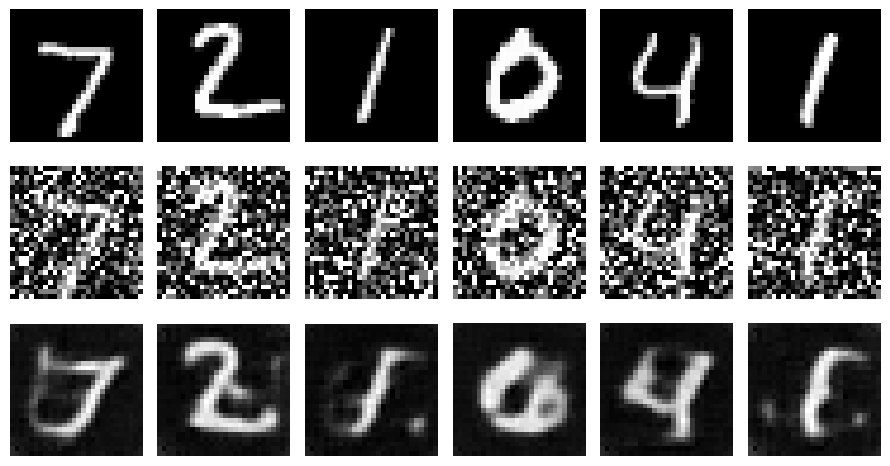

In [15]:
#Models
model_FCAE=FCAutoEncoder()
model_ConvAE=ConvAutoEncoder()
model_VAE=VAE()

#Loss criterion (critere de perte)
#The Mean Squared Error fit better with float values which are between -1 and 1.
criterion=nn.MSELoss()

#Optimizers (with lr=0.001)
optimizer_FCAE  =optim.Adam(model_FCAE.parameters(),lr=1e-3)
optimizer_ConvAE=optim.Adam(model_ConvAE.parameters(),lr=1e-3)
optimizer_VAE   =optim.Adam(model_VAE.parameters(),lr=1e-3) 

# Training and evaluation
def train_evaluate(model,optimizer, num_epochs=5):
    """ Train and Evaluate all different models """
    
    # Training
    best_loss=float("inf")
    start_time=time.time()
    for epoch in range(num_epochs):
        model.train()
        train_loss=0

        if model.__class__ != VAE().__class__: #Only for the Fully connected and Convolution models
            for imgs,_ in train_loader:
                optimizer.zero_grad() # Put all gradiants to zero
                noisy_images=add_gaussian_noise(imgs) # We add noises
                noisy_images=add_salt_pepper(noisy_images)
                new_images=model(noisy_images) # Compute the new images
                loss= criterion(new_images,imgs) 
                loss.backward() # We compute the loss
                optimizer.step() #Update of the parameters model
                train_loss += loss.item() * imgs.size(0)
            train_loss /= len(train_loader.dataset) # compute of the train loss

        else: # for VAE model
            
            for imgs,_ in train_loader:
                optimizer.zero_grad()
                noisy_imgs=add_gaussian_noise(imgs)
                new_imgs,mean,log_std=model(noisy_imgs)
                loss=vae_loss(new_imgs,imgs,mean,log_std)
                loss.backward()
                optimizer.step()
                B,C,H,W=imgs.shape
                train_loss+=loss.item()/(B*C*H*W) # divided by the number of pixel in the batch
            train_loss/=len(train_loader) #divided by the number of batch

        print(f"Époch {epoch+1}/{num_epochs} — Train MSE: {train_loss:.4f} ")

        # We save the best model
        if (best_loss>train_loss):
            best_loss = train_loss
            torch.save(model.state_dict(), f"./best_models/best_{model.__class__}_by_acc.pth")

    end_time=time.time()
    print(f"Runing Time:{end_time-start_time:.4f} seconds")
    
    #Evaluation: made by chatgpt and I modified
    model.eval()
    fig, axes = plt.subplots(3, 6, figsize=(9, 5))
    with torch.no_grad():
        for i, (imgs, _) in enumerate(test_loader):
            if i >= 1: break # We take only the first batchs
            noisy = add_gaussian_noise(imgs)
            noisy = add_salt_pepper(noisy)
            
            if model.__class__ != VAE().__class__:
                recon = model(noisy) # reconstructed image
            else:
                recon,mean,log_std=model(noisy)
            
            for j in range(6):
                # ligne 0: image propre
                axes[0, j].imshow(imgs[j,0], cmap="gray"); axes[0,j].axis("off")
                # ligne 1: image bruitée
                axes[1, j].imshow(noisy[j,0].cpu(), cmap="gray"); axes[1,j].axis("off")
                # ligne 2: reconstruction
                axes[2, j].imshow(recon[j,0].cpu(), cmap="gray"); axes[2,j].axis("off")
            break
    
    axes[0,0].set_ylabel("Original")
    axes[1,0].set_ylabel("Bruitée")
    axes[2,0].set_ylabel("Reconstruite")
    plt.tight_layout()
    plt.show()

    # We return the best model
    state = torch.load(f"./best_models/best_{model.__class__}_by_acc.pth",map_location="cpu")
    model.load_state_dict(state)
    return model




#Runing
print("=======FC AUTO ENCODER=======")
model_FCAE=train_evaluate(model_FCAE, optimizer_FCAE)
print("=======Conv AUTO ENCODER=======")
model_ConvAE=train_evaluate(model_ConvAE, optimizer_ConvAE)
print("=======Var. AUTO ENCODER=======")
model_VAE=train_evaluate(model_VAE, optimizer_VAE)



About the loss of the VAE, we tried to have a mean to compared it with the other models. However we cannot do that because the way to compute the loss for the different models are not all the same. We can only compare their reconstruction which is a little bit more subjective.

# Conclusion



Regarding the different reconstruction made by the models, we can say that:

- The Full connected Auto encoder manage to re-build the original image whith much precision. We could have a little problem with the letter 4 because it could seems like a 9 but it still a satisfying 4. So we did a great full connected auto encoder with only 3 layers.
This model only aims to reduce the MSE between the noisy image and the real one, it has only one task to do and could sometimes memorize the patterns that why it has so good result.
Concerning the time, we can clearly see that this model was by far the fastest of them all .

- The Convolutional Auto Encoder is also a good but not better than the first one. We can notice that the generated images are not totally clear and have in some places white part ( like the 7, 4 and 1). We use for this model only 2 convolutions layers and 2 maxpooling layer, maybe with more convolution layers we could have a better model.
This model take more time to run than the full connected one, it is 3 times longer. Which is logical because here we work in a 2 dimentional space instead of 1 dimentional for the full connected.

- The Variational Auto Encoder is by far the worst model and is not able to re-builf correctly an image.
This problem could have many reasons. Firstly, we could change our loss function to use binary cross-entropy instead of MSE because our image are binary; also the dimension of the latent space is maybe too short to cacth the diversity of the image or too big;...
Concerning the runing time, it last approximatly as long as the convolution auto encoder. 

The goal of this project is not to correct every problem faced by the models but to have a first experience in the implementation of an AE. Let's find our to resolve some problem meet here in another project or maybe after.